In [146]:
import os
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
import scipy.fftpack as fft
import seaborn as sns
import cvxpy as cvx
import cv2 as cv
import datetime
from sklearn.linear_model import Lasso, LassoCV, \
                                OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, \
                                ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from lbfgs import fmin_lbfgs
from tqdm.notebook import tqdm, tnrange
from jupyterthemes import jtplot

In [147]:
%matplotlib inline
jtplot.reset()
# plt.switch_backend('Agg')
sns.set()
sns.set_context("notebook")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100

In [168]:
traindir = "D:/Kenneth/Documents/VIP/Datasets/dr2imagenet/TEST"
sessiondir = f"{datetime.datetime.now().strftime('%Y%m%d')}"
os.makedirs(sessiondir, exist_ok=True)
_b_vector = None
_ri_vector = None
_image_dims = None

In [149]:
def dct2(x):
    return fft.dct(fft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return fft.idct(fft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def lbfgs_evaluate(x, g, *args):
    global _b_vector, _image_dims, _ri_vector
    b = _b_vector
    ri = _ri_vector
    ny, nx = _image_dims
    
    x2 = x.reshape((ny, nx)).T
    Ax2 = idct2(x2)
    Ax = Ax2.T.flat[ri].reshape(b.shape)
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))
    Axb2 = np.zeros(x2.shape)
    Axb2.T.flat[ri] = Axb
    AtAxb2 = 2 * dct2(Axb2)
    AtAxb = AtAxb2.T.reshape(x.shape)
    np.copyto(g, AtAxb)
    return fx

In [150]:
def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """
    Implementation of the Smoothed L0 Optimisation algorithm developed by 
    Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details.
    
    Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10) 

In [159]:
class CS:
    def read_image(self, filename, resize_dim):
        global _image_dims
        self.filename = filename
        self.resize_dim = resize_dim
        _image_dims = (resize_dim, resize_dim)
        
        self.image = cv.imread(self.filename, 0)/255
        self.image = cv.resize(self.image, (resize_dim, resize_dim))
        
    def generate_sequence(self, compress_ratio, seed=402):
        global _ri_vector
        rand.seed(seed)
        N = self.resize_dim
        n_samples = round(N * N * compress_ratio)
        rand_idx = rand.choice(N**2, n_samples, replace=False)
        A = np.kron(fft.idct(np.identity(N), norm='ortho', axis=0), fft.idct(np.identity(N), norm='ortho', axis=0))
        A = A[rand_idx]
        self.compress_ratio = compress_ratio
        self.idx_seq = _ri_vector = rand_idx
        self.sensing_mat = A
        
    def compress(self, image):
        global _b_vector
        b = self.image.T.flat[self.idx_seq]
        self.image_compressed = _b_vector = b
        return b
        
    def decompress(self, image_compressed, solver, **solver_kwargs):
        A = self.sensing_mat
        N = self.resize_dim
        b = image_compressed
        if solver == 'lasso':
            prob = Lasso(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            return y
        elif solver == 'lassocv':
            prob = LassoCV(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            self.prob = prob
            return y
        elif solver == 'cvx':
            vx = cvx.Variable(N*N)
            objective = cvx.Minimize(cvx.norm(vx, 1))
            constraint = [A*vx == b]
            prob = cvx.Problem(objective, constraint)
            res = prob.solve(verbose=True, solver='ECOS')
            beta = np.array(vx.value.reshape((N, N))).squeeze()
            y = idct2(beta.reshape((N, N)).T)
            self.image_recovered = y
            return y
        elif solver == 'omp':
            prob = OrthogonalMatchingPursuit(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            return y
        elif solver == 'ompcv':
            prob = OrthogonalMatchingPursuitCV(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            self.prob = prob
            return y
        elif solver == 'elasticnet':
            prob = ElasticNet(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            return y
        elif solver == 'elasticnetcv':
            prob = ElasticNetCV(**solver_kwargs)
            prob.fit(A, b)
            y = idct2(prob.coef_.reshape((N, N)).T)
            self.image_recovered = y
            self.prob = prob
            return y
        elif solver == 'sl0':
            coef = SL0(A, b)
            y = idct2(coef.reshape((N, N)).T)
            self.image_recovered = y
            return y
        elif solver == 'owlqn':
            b = image_compressed
            nx, ny = self.resize_dim, self.resize_dim
            ri = self.idx_seq
            coef = fmin_lbfgs(lbfgs_evaluate, np.ones_like(self.image), orthantwise_c=5)
            y = idct2(coef.reshape((N, N)).T)
            self.image_recovered = y
        else:
            raise NotImplementedError
            
    def show_image(self, save=None):
        plt.imshow(self.image, 'gray')
        plt.axis('off')
        if save is not None:
            plt.savefig(save, dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
        
    def show_mask(self, save=None):
        mask = np.zeros_like(self.image, 'uint8')
        mask.flat[self.idx_seq] = 1
        masked = np.zeros_like(self.image)
        masked.flat[self.idx_seq] = self.image.flat[self.idx_seq]
        
        fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
        ax[0].imshow(self.image, 'gray')
        ax[0].set_title('train')
        ax[1].imshow(masked, 'gray')
        ax[1].set_title(f'sample {int(self.compress_ratio*100)}%')
        for i in range(2):
            ax[i].grid(0)
            ax[i].axis('off')
        if save is not None:
            plt.savefig(save, dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
        
    def show_sensing_matrix(self, save=None):
        plt.imshow(self.sensing_mat, 'gray')
        plt.grid(0)
        plt.title('sensing matrix')
        if save is not None:
            plt.savefig(save, dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
        
    def show_recovered(self, hold='off', save=None):
        x = self.image
        y = self.image_recovered
        x -= x.min()
        x /= x.max()
        y -= y.min()
        y /= y.max()
        metric = ssim(x, y)
        
        plt.imshow(y, 'gray')
        plt.title(f'recovered from {int(self.compress_ratio*100)}%, SSIM = {metric:.2f}')
        plt.grid(0)
        plt.axis('off')
        if save is not None:
            plt.savefig(save, dpi=300, transparent=True, bbox_inches='tight')
        if hold == 'off':
            plt.show()
        self.metric = metric

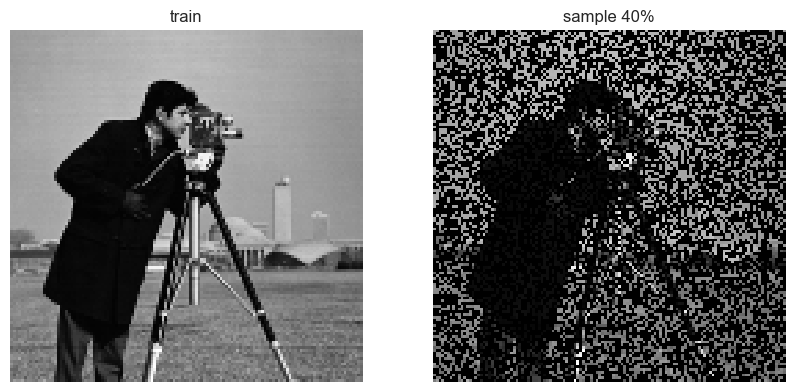

In [169]:
sess = CS()
sess.read_image(f'{traindir}/cameraman.png', 128)
sess.generate_sequence(0.40)
comp = sess.compress(sess.image)
sess.show_mask(save=f'{sessiondir}/train40.png')

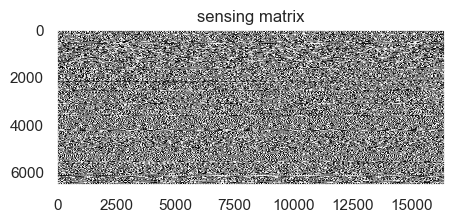

In [170]:
sess.show_sensing_matrix(save=f'{sessiondir}/train40_sensmat.png')

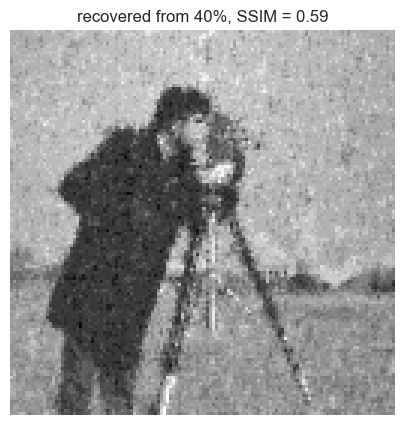

In [173]:
rec = sess.decompress(comp, 'sl0')
sess.show_recovered(save=f'{sessiondir}/recover40_same.png')

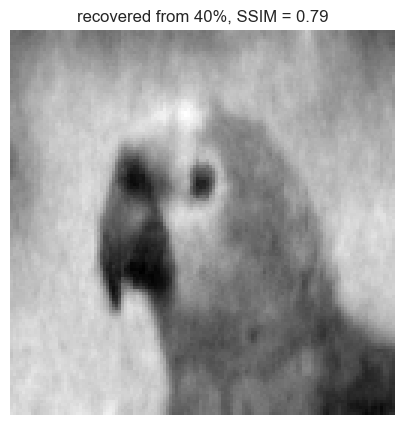

In [182]:
sess.read_image(f'{traindir}/parrot.png', 128)
comp = sess.compress(sess.image)
rec = sess.decompress(comp, 'lasso', alpha=1e-5)
sess.show_recovered(save=f'{sessiondir}/recover40_parrot.png')